## Read time series data and split

In [2]:
import pandas as pd
import numpy as np
import jax

# Disable JIT compilation
#jax.config.update("jax_disable_jit", True)
#jax.config.update("jax_log_compiles", True)

import jax.numpy as jnp
import discretize_func as discretize
import tokenizer_func as tokenizer
import inference_func as inference
import pickle
import matplotlib.pyplot as plt

jax 0.4.28 jaxlib 0.4.28
cpu
[CpuDevice(id=0)]


In [3]:
import os
from pathlib import Path

# Read
df = pd.read_parquet(Path("../data") / "dehli.parquet")

# Fill nans with nearest
df = df.ffill()

# Downsample from 5-min resolution to hourly
#df = df.resample("h").mean()

# Downsample from 5-min resolution to quarterly
df = df.resample("15min").mean()

# Change to numeric index (remove datetime)
#df = df.reset_index(drop=True)

# Fill nans with nearest
df = df.ffill()

# Columns of interest
cols = ['Power demand', 'temp', 'dwpt', 'rhum', 'wdir', 'wspd', 'pres']
df = df[cols]

# Split in train/test
split_idx = int(len(df) * 0.8)
X = df.iloc[:split_idx].copy()
Y = df.iloc[split_idx:].copy()

## Pre-processing

* Normalize
* Delta tokens by derivation
* Global discretization

Current setup:
* delta tokens
* n_bins = 1024
* fixed size bins

Future:
* discretize each column individually
* quantile-based bins (centered at 0)

## Tokenize
* Tokenize each row: Channel+Value (on change), special time step token: 0

Token layout

* 0	BOS (beginning of sequence / row)
* CH_0 … CH_6  →  IDs 2 … 8 (channel tokens)
* DATA ≥ DATA_OFFSET = 2 + N_CHANNELS = 9 (data tokens)
* 1	EOS (end of row)

Example:

```python
[BOS,
 CH_0, DATA(x0),
 CH_1, DATA(x1),
 ...
 CH_6, DATA(x6),
 EOS]
```

# Read model

In [4]:
# Load model
with open('../models/token_model_20251222_140751.pkl', 'rb') as f:
    model_file = pickle.load(f)

globals().update(model_file)
ZERO_BIN = int(np.argmin(np.abs(mids)))

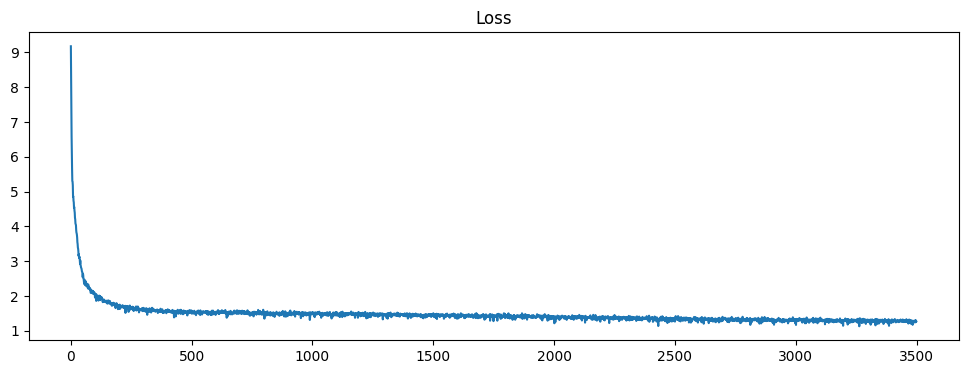

In [5]:
plt.figure(figsize=(12, 4))
plt.plot(losses)
plt.title('Loss')
plt.show()

## Autoregressive rollout
* Feed in test_tokens context window (same context +1 out)
* Generate one new token, add to context, adhere to grammar
* When a new full sparse frame is complete, [BOS, CH+DATA.., EOS], we make a new row
* Stop when we have stepped block_size (context window size)
* We should now have a dataframe of new deltas

TODO A later test would be to make new test_tokens with minimal columns and see if the model propose covariates.

In [6]:
rng_key = jax.random.PRNGKey(128)

In [62]:
rng_key, subkey = jax.random.split(rng_key)
max_new_tokens = 96
t = int(jax.random.randint(rng_key, shape=(), minval=0, maxval=len(X)-(3*max_new_tokens)))

# Select a random batch (t)
X_test = X.iloc[t:t+max_new_tokens]
Y_test = X.iloc[t+max_new_tokens:t+max_new_tokens+max_new_tokens]

# Pre-process it
X_test_normalized = (X_test-mu)/sigma
X_test_normalized = X_test_normalized.diff().dropna()
X_test_nv = X_test_normalized.values.astype(np.float32)   # (N, D)

# Discretize
X_test_tok = discretize.encode_equal_width_global(jnp.asarray(X_test_nv), edges)
test_tokens = tokenizer.encode_with_channels_sparse(X_test_tok, n_channels, ZERO_BIN)
token_stream = test_tokens[-block_size:] # B, T

# Inspect first few tokens
print("Number of tokens:", len(test_tokens))
print("Number of tokens in stream:", len(token_stream))
print("Context window:", block_size)
print("Last context tokens:", token_stream)

Number of tokens: 580
Number of tokens in stream: 480
Context window: 480
Last context tokens: [   0    2 1939    3 1930    4 1988    5 2061    8 1906    1    0    2
 1942    1    0    2 1944    1    0    2 1943    1    0    2 1948    1
    0    2 1946    1    0    2 1948    1    0    2 1948    1    0    2
 1950    3 1935    4 1918    5 1924    8 1984    1    0    2 1949    1
    0    2 1951    1    0    2 1950    1    0    2 1953    3 1941    4
 1955    5 1979    6 2405    7 2247    8 1887    1    0    2 1953    1
    0    2 1954    1    0    2 1957    1    0    2 1958    3 1924    4
 1921    6 1498    7 1656    8 2003    1    0    2 1959    1    0    2
 1967    1    0    2 1971    1    0    2 1972    3 1957    4 1942    5
 1924    6 2386    7 2247    8 1945    1    0    2 1976    1    0    2
 1981    1    0    2 1989    1    0    2 1984    3 1946    4 1961    5
 1979    6 1989    8 1939    1    0    2 1987    1    0    2 1993    1
    0    2 1997    1    0    2 1986    8 1984    1   

In [63]:
rng_key, subkey = jax.random.split(rng_key)
token_stream_padded = inference.pad_tokens(token_stream)

new_tokens = inference.generate_continue(
    variables,
    model.apply,
    token_stream=token_stream,
    rng_key=rng_key,
    vocab_size=vocab_size,
    block_size=block_size,
    max_new_tokens=max_new_tokens,
    n_channels=n_channels,
)

In [64]:
# Convert from stream to channel matrix
tokens_padded = inference.pad_tokens(new_tokens)
rows, n = inference.decode_with_channels_stream(tokens_padded, n_channels)
new_Y_tok = rows[:n]
new_Y_tok

Array([[1932,    0,    0,    0,    0,    0,    0],
       [1939,    0,    0,    0,    0,    0,    0],
       [1946,    0,    0,    0,    0,    0,    0],
       [   0,    0, 2013,    0,    0,    0,    0],
       [1946,    0,    0,    0,    0,    0,    0],
       [   0,    0, 2013,    0,    0,    0,    0],
       [1946,    0,    0,    0,    0,    0,    0],
       [1946, 2013,    0,    0,    0,    0,    0],
       [1946,    0,    0,    0,    0,    0,    0],
       [1946,    0,    0,    0,    0,    0,    0],
       [   0, 2013,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0, 1924,    0,    0],
       [   0,    0, 2013,    0,    0,    0,    0],
       [   0, 2013,    0,    0,    0,    0,    0],
       [1946,    0,    0,    0,    0,    0,    0],
       [1932,    0, 2013,    0,    0,    0,    0],
       [1932,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0, 1975],
       [1946,    0,    0,    0,    0,    0, 1975],
       [   0, 2013,    0,    0,

Delta model, so mu is not added back

$$
\frac{(x_t - \mu) - (x_{t-1} - \mu)}{\sigma}
\quad\equiv\quad
\frac{x_t - x_{t-1}}{\sigma}
$$

In [65]:
# Decode tokens to deltas, cumsum with initial value, and de-normalize
Y_rec = discretize.decode_equal_width_global(new_Y_tok, mids)
Y_rec = pd.DataFrame(Y_rec, columns=X_test_normalized.columns)
Y_rec = Y_rec * sigma # delta model so mu is not added back
init_values = X_test.iloc[-1].values
Y_pred = init_values + jnp.cumsum(Y_rec.values, axis=0)

Y_test = X.iloc[t+max_new_tokens:t+max_new_tokens+len(Y_rec)]
Y_pred = pd.DataFrame(Y_pred, columns=X_test_normalized.columns, index=Y_test.index)
Y_pred

,Power demand,temp,dwpt,rhum,wdir,wspd,pres
datetime,,,,,,,
2021-12-29 19:45:00,3311.889893,15.000000,8.900000,67.0,250.00000,5.4,1020.000000
2021-12-29 20:00:00,3292.001465,15.000000,8.900000,67.0,250.00000,5.4,1020.000000
2021-12-29 20:15:00,3311.067871,15.000000,8.900000,67.0,250.00000,5.4,1020.000000
2021-12-29 20:30:00,3311.067871,15.000000,11.201637,67.0,250.00000,5.4,1020.000000
2021-12-29 20:45:00,3330.134277,15.000000,11.201637,67.0,250.00000,5.4,1020.000000
2021-12-29 21:00:00,3330.134277,15.000000,13.503275,67.0,250.00000,5.4,1020.000000
2021-12-29 21:15:00,3349.200684,15.000000,13.503275,67.0,250.00000,5.4,1020.000000
2021-12-29 21:30:00,3368.267090,17.570856,13.503275,67.0,250.00000,5.4,1020.000000
2021-12-29 21:45:00,3387.333740,17.570856,13.503275,67.0,250.00000,5.4,1020.000000


In [66]:
Y_test

,Power demand,temp,dwpt,rhum,wdir,wspd,pres
datetime,,,,,,,
2021-12-29 19:45:00,3317.593333,15.0,8.9,67.0,250.0,5.4,1020.0
2021-12-29 20:00:00,3228.766667,15.0,8.9,67.0,250.0,5.4,1020.0
2021-12-29 20:15:00,3168.613333,15.0,8.9,67.0,250.0,5.4,1020.0
2021-12-29 20:30:00,3112.696667,13.4,8.7,73.0,0.0,0.0,1021.8
2021-12-29 20:45:00,3037.546667,13.4,8.7,73.0,0.0,0.0,1021.8
2021-12-29 21:00:00,2948.070000,13.4,8.7,73.0,0.0,0.0,1021.8
2021-12-29 21:15:00,2900.726667,13.4,8.7,73.0,0.0,0.0,1021.8
2021-12-29 21:30:00,2900.080000,13.0,9.1,77.0,0.0,0.0,1022.0
2021-12-29 21:45:00,2822.833333,13.0,9.1,77.0,0.0,0.0,1022.0


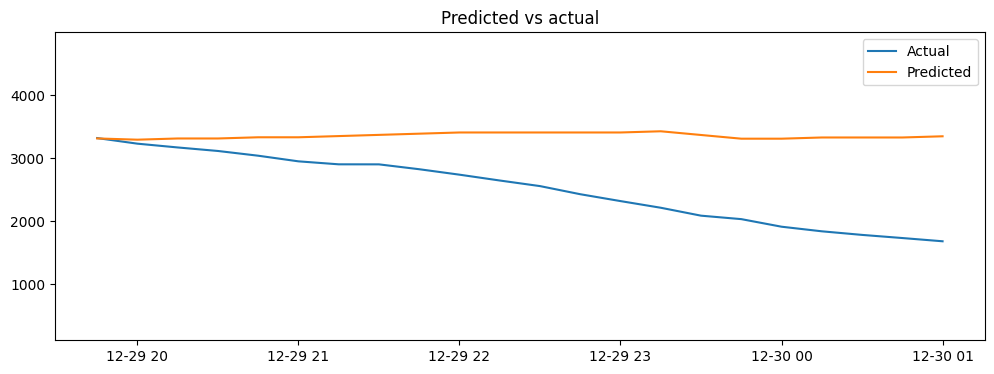

In [68]:
col = 'Power demand'
#col = "rhum"
#col = "temp"

y = np.concatenate([Y_test[col].values, Y_pred[col].values])
ymin, ymax = y.min(), y.max()
yrange = ymax - ymin
pad = 0.90 * yrange   # 20% extra headroom

plt.figure(figsize=(12, 4))
plt.plot(Y_test.index, Y_test[col], label="Actual")
plt.plot(Y_pred.index, Y_pred[col], label="Predicted")
plt.ylim(ymin - pad, ymax + pad)
plt.title('Predicted vs actual')
plt.legend()
plt.show()

## Autoregressive rollout with covariates

* Specify covariates values

In [38]:
# TODO!

## Autoregressive channel hinter

Lets mask away some channels and see if the model hints about the missing channels.

In [73]:
rng_key, subkey = jax.random.split(rng_key)
max_new_tokens = 96
t = int(jax.random.randint(rng_key, shape=(), minval=0, maxval=len(X)-(3*max_new_tokens)))

# Select a random batch (t)
X_test = X.iloc[t:t+max_new_tokens]
Y_test = X.iloc[t+max_new_tokens:t+max_new_tokens+max_new_tokens].reset_index(drop=True)

# Pre-process it
X_test_normalized = (X_test-mu)/sigma
X_test_normalized = X_test_normalized.diff().dropna()

# Mask out channel 1, 4->
n_cols = X_test_normalized.shape[1]
mask = np.ones(n_cols, dtype=bool)
mask[[1]] = False
mask[2:] = False

X_masked = X_test_normalized.copy()
X_masked.loc[:, ~mask] = 0

X_masked_nv = X_masked.values.astype(np.float32)   # (N, D)

# Discretize
X_masked_tok = discretize.encode_equal_width_global(jnp.asarray(X_masked_nv), edges)
masked_tokens = tokenizer.encode_with_channels_sparse(X_masked_tok, n_channels, ZERO_BIN)
masked_stream = masked_tokens[-block_size:] # B, T

# Inspect first few tokens
print("Number of tokens:", len(masked_tokens))
print("Number of tokens in stream:", len(masked_stream))
print("Context window:", block_size)
print("Last context tokens:", masked_stream)

Number of tokens: 368
Number of tokens in stream: 368
Context window: 480
Last context tokens: [   0    2 1946    1    0    2 1946    1    0    2 1948    1    0    2
 1949    1    0    2 1947    1    0    2 1948    1    0    2 1950    1
    0    2 1949    1    0    2 1950    1    0    1    0    2 1951    1
    0    1    0    2 1954    1    0    2 1954    1    0    2 1957    1
    0    2 1958    1    0    2 1961    1    0    2 1966    1    0    2
 1967    1    0    2 1965    1    0    2 1975    1    0    2 1977    1
    0    2 1973    1    0    2 1969    1    0    2 1969    1    0    2
 1967    1    0    2 1961    1    0    2 1956    1    0    2 1963    1
    0    2 1954    1    0    2 1954    1    0    2 1954    1    0    2
 1955    1    0    2 1972    1    0    2 1969    1    0    2 1963    1
    0    2 1951    1    0    1    0    2 1944    1    0    2 1958    1
    0    2 1950    1    0    2 1950    1    0    2 1950    1    0    2
 1928    1    0    2 1951    1    0    2 1958    1   

In [74]:
X_masked

,Power demand,temp,dwpt,rhum,wdir,wspd,pres
datetime,,,,,,,
2021-12-03 01:00:00,-0.023874,0.0,0.0,0.0,0.0,0.0,0.0
2021-12-03 01:15:00,-0.023410,0.0,0.0,0.0,0.0,0.0,0.0
2021-12-03 01:30:00,-0.013963,0.0,0.0,0.0,0.0,0.0,0.0
2021-12-03 01:45:00,-0.009508,0.0,0.0,0.0,0.0,0.0,0.0
2021-12-03 02:00:00,-0.019513,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
2021-12-03 23:30:00,-0.039332,0.0,0.0,0.0,0.0,0.0,0.0
2021-12-03 23:45:00,-0.042947,0.0,0.0,0.0,0.0,0.0,0.0
2021-12-04 00:00:00,0.785979,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
masked_stream_padded = inference.pad_tokens(masked_stream)
new_masked_tokens = inference.generate_continue(
    variables,
    model.apply,
    token_stream=masked_stream_padded,
    rng_key=rng_key,
    vocab_size=vocab_size,
    block_size=block_size,
    max_new_tokens=max_new_tokens,
    n_channels=n_channels,
)

In [76]:
# Convert from sparse stream to all channel matrix
new_masked_tokens_padded = inference.pad_tokens(new_masked_tokens)
rows, n = inference.decode_with_channels_stream(new_masked_tokens_padded, n_channels)
new_masked_tok = rows[:n]
new_masked_tok

Array([[   0,    0,    0,    0, 1924, 2013,    0],
       [   0,    0, 2013,    0,    0,    0,    0],
       [   0,    0, 2013,    0,    0,    0,    0],
       [   0, 2013,    0,    0,    0,    0,    0],
       [   0, 2013,    0,    0,    0,    0,    0],
       [   0, 2013,    0,    0,    0,    0,    0],
       [   0,    0, 2013,    0,    0,    0,    0],
       [   0, 2013,    0,    0,    0,    0,    0],
       [   0, 2013,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0, 1924,    0,    0],
       [   0,    0, 2013,    0,    0,    0,    0],
       [   0, 2013,    0,    0,    0,    0,    0],
       [1939,    0, 2013,    0,    0, 2013, 1939],
       [   0, 2013,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0, 1933],
       [1939,    0,    0,    0,    0,    0, 1939],
       [   0, 2013,    0,    0,    0,    0,    0],
       [   0, 2013,    0,    0,    0,    0, 1933]], dtype=int32)

In [77]:
# Decode tokens to deltas, cumsum with initial value, and de-normalize
Y_masked_rec = discretize.decode_equal_width_global(new_masked_tok, mids)
Y_masked_rec = pd.DataFrame(Y_masked_rec, columns=X.columns)
Y_masked_rec = Y_masked_rec * sigma # delta model so mu is not added back

pd.DataFrame(Y_masked_rec)

,Power demand,temp,dwpt,rhum,wdir,wspd,pres
0,0.000000,0.000000,0.000000,0.0,-9.829884,1.812236,0.000000
1,0.000000,0.000000,2.301638,0.0,0.000000,0.000000,0.000000
2,0.000000,0.000000,2.301638,0.0,0.000000,0.000000,0.000000
3,0.000000,2.570856,0.000000,0.0,0.000000,0.000000,0.000000
4,0.000000,2.570856,0.000000,0.0,0.000000,0.000000,0.000000
5,0.000000,2.570856,0.000000,0.0,0.000000,0.000000,0.000000
6,0.000000,0.000000,2.301638,0.0,0.000000,0.000000,0.000000
7,0.000000,2.570856,0.000000,0.0,0.000000,0.000000,0.000000
8,0.000000,2.570856,0.000000,0.0,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.0,-9.829884,0.000000,0.000000


In [78]:
# Cumsum
init_values = X_test.iloc[-1].values
Y_masked_pred = init_values + jnp.cumsum(Y_masked_rec.values, axis=0)

Y_test = X.iloc[t+max_new_tokens:t+max_new_tokens+len(Y_masked_pred)]
Y_masked_pred = pd.DataFrame(Y_masked_pred, columns=X.columns, index=Y_test.index)

Y_masked_pred

,Power demand,temp,dwpt,rhum,wdir,wspd,pres
datetime,,,,,,,
2021-12-04 00:45:00,3173.356689,17.000000,15.000000,88.0,-9.829885,1.812236,1018.000000
2021-12-04 01:00:00,3173.356689,17.000000,17.301638,88.0,-9.829885,1.812236,1018.000000
2021-12-04 01:15:00,3173.356689,17.000000,19.603275,88.0,-9.829885,1.812236,1018.000000
2021-12-04 01:30:00,3173.356689,19.570856,19.603275,88.0,-9.829885,1.812236,1018.000000
2021-12-04 01:45:00,3173.356689,22.141712,19.603275,88.0,-9.829885,1.812236,1018.000000
2021-12-04 02:00:00,3173.356689,24.712566,19.603275,88.0,-9.829885,1.812236,1018.000000
2021-12-04 02:15:00,3173.356689,24.712566,21.904915,88.0,-9.829885,1.812236,1018.000000
2021-12-04 02:30:00,3173.356689,27.283424,21.904915,88.0,-9.829885,1.812236,1018.000000
2021-12-04 02:45:00,3173.356689,29.854279,21.904915,88.0,-9.829885,1.812236,1018.000000


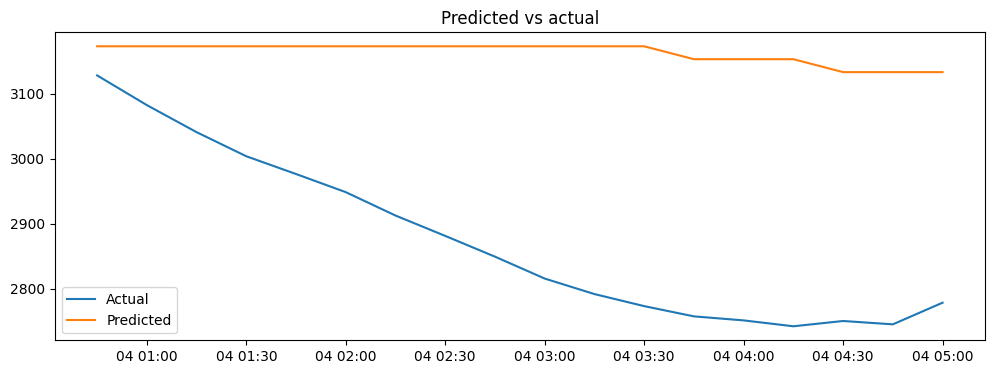

In [79]:
col = 'Power demand'
#col = 'temp'
plt.figure(figsize=(12, 4))
plt.plot(Y_test.index, Y_test[col], label="Actual")
plt.plot(Y_masked_pred.index, Y_masked_pred[col], label="Predicted")
plt.title('Predicted vs actual')
plt.legend()
plt.show()